In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2

In [2]:
data = pd.read_csv("ferplus_filtered.csv")
data.head()

,Unnamed: 0,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt
0,0,train,fer0000000.png,0.400000,0.0,0.000,0.100000,0.300000,0.2,0.0,0.0
1,1,train,fer0000001.png,0.750000,0.0,0.125,0.125000,0.000000,0.0,0.0,0.0
2,2,train,fer0000002.png,0.555556,0.0,0.000,0.333333,0.111111,0.0,0.0,0.0
3,3,train,fer0000003.png,0.444444,0.0,0.000,0.444444,0.111111,0.0,0.0,0.0
4,4,train,fer0000004.png,0.900000,0.0,0.000,0.100000,0.000000,0.0,0.0,0.0


In [3]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35488 entries, 0 to 35487
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Usage       35488 non-null  object 
 1   Image name  35488 non-null  object 
 2   neutral     35488 non-null  float64
 3   happiness   35488 non-null  float64
 4   surprise    35488 non-null  float64
 5   sadness     35488 non-null  float64
 6   anger       35488 non-null  float64
 7   disgust     35488 non-null  float64
 8   fear        35488 non-null  float64
 9   contempt    35488 non-null  float64
dtypes: float64(8), object(2)
memory usage: 2.7+ MB


In [5]:
data["Usage"].value_counts()

train         28389
validation     3553
test           3546
Name: Usage, dtype: int64

### Генерация данных для обучения/тестов

In [6]:
def gen_set(usage="train"):
    df = data[data["Usage"] == usage]
    path = "fer2013/"
    if usage == "train":
        path += 'train/'
    elif usage == "validation" or usage == "test":
        path += 'test/'
    data_X = np.array([cv2.imread(path+x) for x in df["Image name"]])
    data_Y = df[["neutral", "happiness", "surprise", "sadness", "anger", "disgust", "fear", "contempt"]]
    return data_X, data_Y

train_data_X, train_data_Y = gen_set(usage="train")
val_data_X, val_data_Y = gen_set(usage="validation")
test_data_X, test_data_Y = gen_set(usage="test")
print(f"train data X shape = {train_data_X.shape}, train data Y shape = {train_data_Y.shape}")
print(f"val_data_X shape = {val_data_X.shape}, val_data_Y shape = {val_data_Y.shape}")
print(f"test_data_X shape = {test_data_X.shape}, test_data_Y shape = {test_data_Y.shape}")

train data X shape = (28389, 48, 48, 3), train data Y shape = (28389, 8)
val_data_X shape = (3553, 48, 48, 3), val_data_Y shape = (3553, 8)
test_data_X shape = (3546, 48, 48, 3), test_data_Y shape = (3546, 8)


### Создание модели

In [7]:
num_features = 64
width = 48
height = 48
num_classes = 8

model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

In [8]:
batch_size = 64
num_epochs = 50

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_data_X, train_data_Y, batch_size),
                                steps_per_epoch=len(train_data_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_data_X, val_data_Y))

Epoch 1/50


C:\Users\User\AppData\Local\Temp\ipykernel_9104\454771958.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_data_X, train_data_Y, batch_size),


443/443 - 28s - loss: 1.5080 - accuracy: 0.5011 - val_loss: 1.7038 - val_accuracy: 0.4621 - 28s/epoch - 64ms/step
Epoch 2/50
443/443 - 23s - loss: 1.1956 - accuracy: 0.6562 - val_loss: 1.2754 - val_accuracy: 0.5944 - 23s/epoch - 51ms/step
Epoch 3/50
443/443 - 23s - loss: 1.0940 - accuracy: 0.7024 - val_loss: 1.1131 - val_accuracy: 0.7036 - 23s/epoch - 51ms/step
Epoch 4/50
443/443 - 23s - loss: 1.0421 - accuracy: 0.7295 - val_loss: 1.0393 - val_accuracy: 0.7284 - 23s/epoch - 51ms/step
Epoch 5/50
443/443 - 22s - loss: 1.0058 - accuracy: 0.7486 - val_loss: 1.0330 - val_accuracy: 0.7228 - 22s/epoch - 51ms/step
Epoch 6/50
443/443 - 22s - loss: 0.9834 - accuracy: 0.7560 - val_loss: 0.9786 - val_accuracy: 0.7546 - 22s/epoch - 51ms/step
Epoch 7/50
443/443 - 23s - loss: 0.9624 - accuracy: 0.7667 - val_loss: 0.9548 - val_accuracy: 0.7712 - 23s/epoch - 51ms/step
Epoch 8/50
443/443 - 23s - loss: 0.9465 - accuracy: 0.7791 - val_loss: 0.9909 - val_accuracy: 0.7450 - 23s/epoch - 51ms/step
Epoch 9/50


In [35]:
model.save('./model/ferplus_cnn')

INFO:tensorflow:Assets written to: ./model/ferplus_cnn\assets


In [13]:
history.history

{'loss': [1.5080139636993408,
  1.1955863237380981,
  1.0939687490463257,
  1.0421241521835327,
  1.0058369636535645,
  0.9834072589874268,
  0.9623900055885315,
  0.9464650750160217,
  0.9354591965675354,
  0.9221512675285339,
  0.9131107330322266,
  0.9025390148162842,
  0.8969160914421082,
  0.8889154195785522,
  0.877197265625,
  0.8727055191993713,
  0.868482768535614,
  0.8611842393875122,
  0.8548768162727356,
  0.8518666625022888,
  0.8459288477897644,
  0.8427675366401672,
  0.8404917120933533,
  0.8348091244697571,
  0.8312087059020996,
  0.8244394063949585,
  0.8243153691291809,
  0.8176260590553284,
  0.8184446692466736,
  0.8119710087776184,
  0.8095816373825073,
  0.8074661493301392,
  0.8041829466819763,
  0.800312876701355,
  0.7963782548904419,
  0.7937318086624146,
  0.7932692170143127,
  0.7897855639457703,
  0.78928142786026,
  0.7842393517494202,
  0.7826583981513977,
  0.7823072075843811,
  0.779090404510498,
  0.778204083442688,
  0.7742681503295898,
  0.77261006

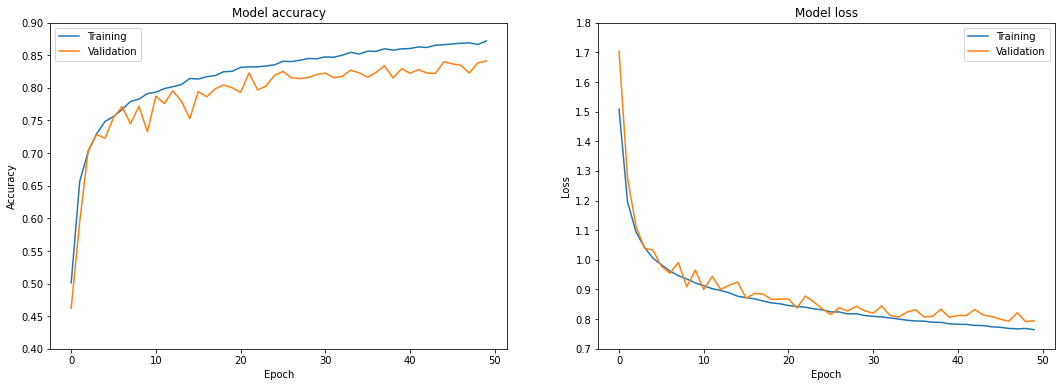

In [31]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
axes[0].plot(history.history['accuracy'], label="Training")
axes[0].plot(history.history['val_accuracy'], label="Validation")
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].set_yticks(np.arange(0.4, 0.95, 0.05))
axes[1].plot(history.history['loss'], label="Training")
axes[1].plot(history.history['val_loss'], label="Validation")
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_yticks(np.arange(0.7, 1.9, 0.1))
plt.show()

In [34]:
results = model.evaluate(test_data_X, test_data_Y, batch_size=64)
print("test loss, test acc:", results)

56/56 [==============================] - 1s 16ms/step - loss: 0.8228 - accuracy: 0.8347
test loss, test acc: [0.8228117823600769, 0.8347433805465698]
